In [2]:
import os
path = os.path.abspath(os.getcwd())

In [3]:
%run -i common_functions

# I/ Data Formatting

In [4]:
# FILES

all_data_files = [
     'moduntu_HP_desktop_trace_idle_22.12.14_6h',
     'moduntu_HP_desktop_trace_idle_22.12.15_20h',
     'moduntu_HP_desktop_trace_no-wifi_22.12.16_19h',
     'moduntu_HP_server_trace_idle_22.12.21_16h',
     'moduntu_HP_server_trace_no-wifi_22.12.20_16h',
     'moduntu_RPi_server32_trace_no-peri_23.01.19_17h',
     'moduntu_RPi_server32_trace_no-wifi_23.01.18_14h',
     'moduntu_VM_desktop_trace_idle_22.11.15_1h',
     'moduntu_VM_desktop_trace_idle_22.12.13_12h',
     'moduntu_VM_desktop_trace_no-wifi_23.01.18_14h',
     'moduntu_VM_server_trace_idle_22.12.13_9h',
     'moduntu_VM_server_trace_no-wifi_23.01.18_14h']

data_files = [  
     'moduntu_HP_desktop_trace_no-wifi_22.12.16_19h',
     'moduntu_HP_server_trace_no-wifi_22.12.20_16h',
     'moduntu_RPi_server32_trace_no-peri_23.01.19_17h',
     'moduntu_VM_desktop_trace_no-wifi_23.01.18_14h',
     'moduntu_VM_server_trace_no-wifi_23.01.18_14h'
]

file = data_files[0]

## A. Text to CSV

In [5]:
def txtdmp_to_csv(filename):
    with open("data/" + filename + ".txt", "r") as textfile:
        textdump = textfile.read().splitlines()
        
    csvfile = open("csv/" + filename + ".csv", "w")
    csvfile.write(','.join(["count", "input1", "input2", "source_id", "idle"]))
    csvfile.write('\n')

    count = 0
    for line in textdump: 
        splitline = line.replace('@','').replace(',','').split(' ')
        values, start, idle = [], False, False

        for i in splitline: 
            # extract fast_mix values
            if i == "fast_mix:":
                start = True
                count += 1
                values.append(str(count))
            elif start:
                values.append(i)

            # Check for idle
            if i == "<idle>-0":
                idle = True

        if values != []:
            values.append(str(idle))
            csvfile.write(','.join(values))
            csvfile.write('\n')

    csvfile.close()

## B. Data Import

In [6]:
# Show stats for 'idle' column.
data_path = path + "\\csv\\" + file + ".csv"
data = pd.read_csv(data_path)

print(file)
for col in ["idle"]:
    get_stats(data, col)

moduntu_HP_desktop_trace_no-wifi_22.12.16_19h
    Stats for idle :
        True		 4218471		 99%
        False		 23268		 1%



In [7]:
data.head(3)

,count,input1,input2,source_id,idle
0,1,30342779072,18446744071864555537,0,True
1,2,30351947516,18446744071864555537,0,True
2,3,30361129622,18446744071864555537,0,True


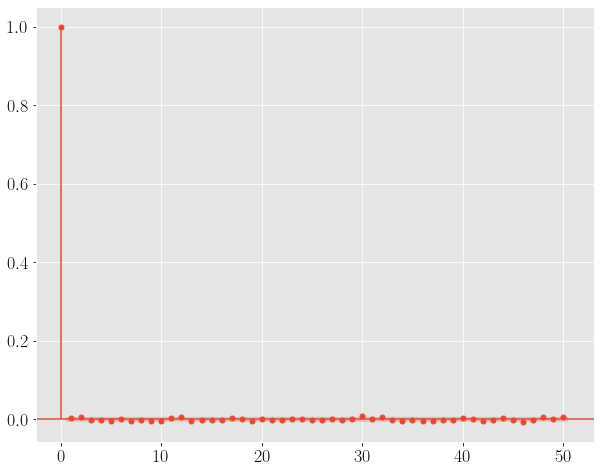

In [15]:
x = np.random.rand(100000)
fig = plot_acf(x, fft=True, title=None)

# II/ Analysis of the Timestamp

## A. Undifferenced Variable

### 1) Direct Plotting

Plot of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 0
	 selection: []
	 crop values: 0, 0
	 # of elements: 4241739
	 log = False


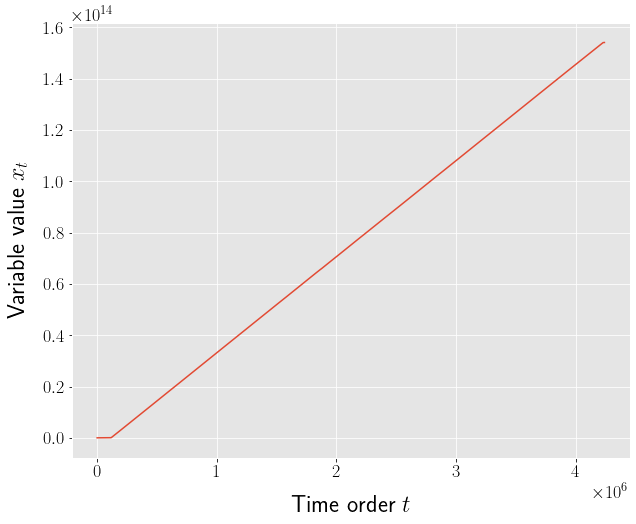

In [8]:
data_plot(file, 'input1', log=False, ylabel=r'Variable value $x_t$')

Plot of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 0
	 selection: [('idle', True)]
	 crop values: 843694, 843694
	 # of elements: 2531083
	 log = True


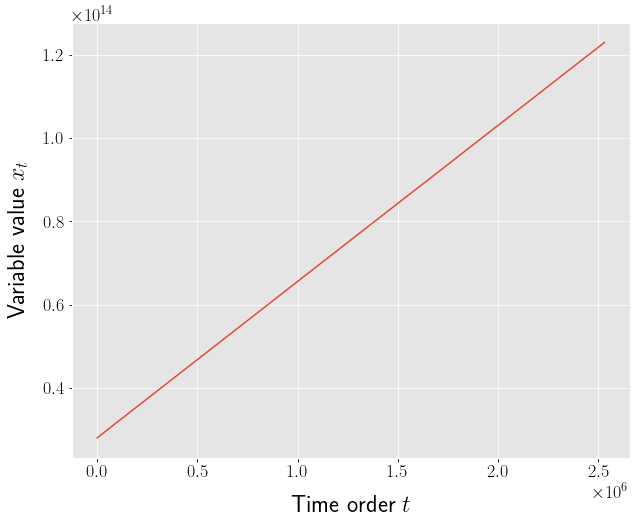

In [28]:
data_plot(file, 'input1', selection = [('idle', True)], crop = (0.2, 0.2), log = True,
          ylabel=r'Variable value $x_t$')

### 2) Histogram

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 0
	 selection: []
	 crop values: 0, 0
	 # of elements: 4241739
	 # of bins: 2059
	 log = False


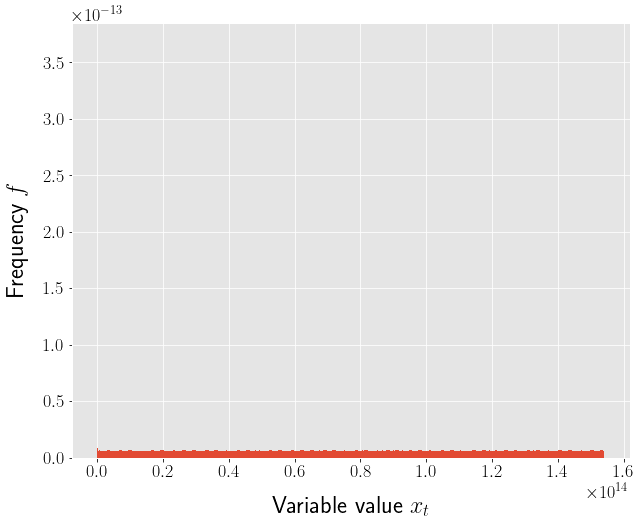

In [10]:
data_hist(file, 'input1', log=False, xlabel=r'Variable value $x_t$')

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 0
	 selection: [('idle', True)]
	 crop values: 843694, 843694
	 # of elements: 2531083
	 # of bins: 1590
	 log = False


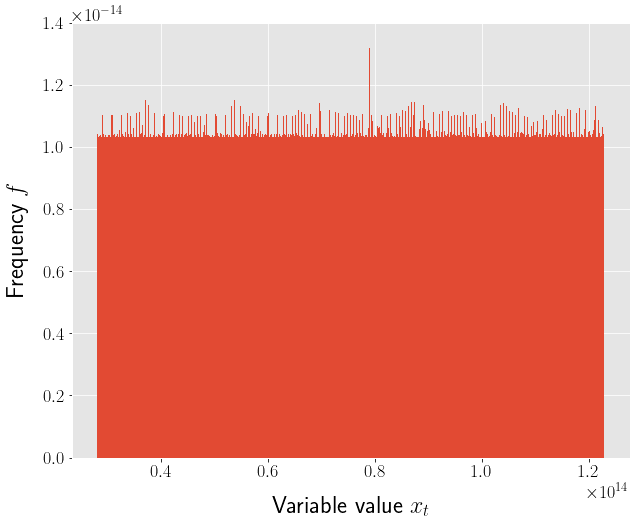

In [27]:
data_hist(file, 'input1', selection = [('idle', True)], crop = (0.2, 0.2), log = False,
          xlabel=r'Variable value $x_t$')

### 3) Correlogram

Correlogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 0
	 selection: []
	 crop values: 0, 0
	 # of elements: 4241739


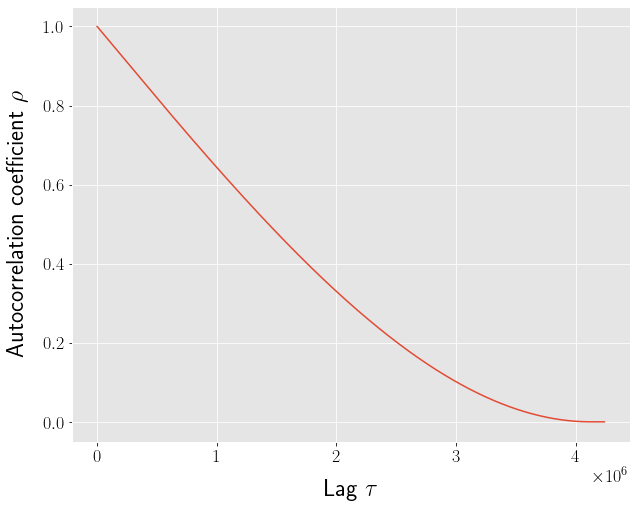

In [12]:
data_autocorr(file, 'input1', mode='fft', diff_order=0)

Correlogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 0
	 selection: []
	 crop values: 0, 0
	 # of elements: 4241739


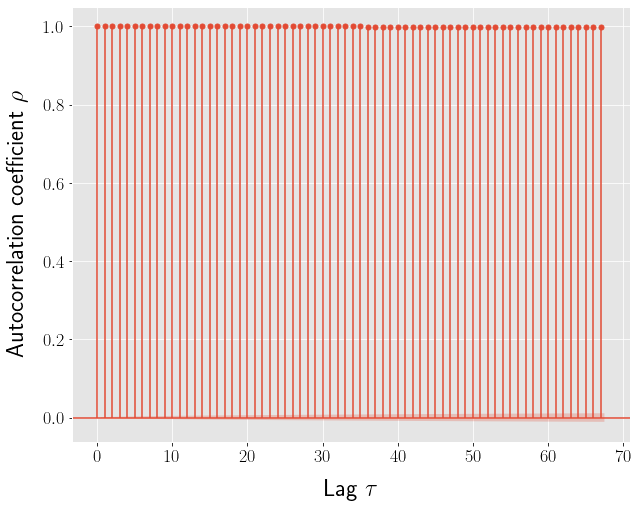

In [13]:
data_autocorr(file, 'input1', mode='acf', diff_order=0)

## B. First-Order Differencing

### 1) Histogram

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 1
	 selection: []
	 crop values: 0, 0
	 # of elements: 4241739
	 # of bins: 2059
	 log = True


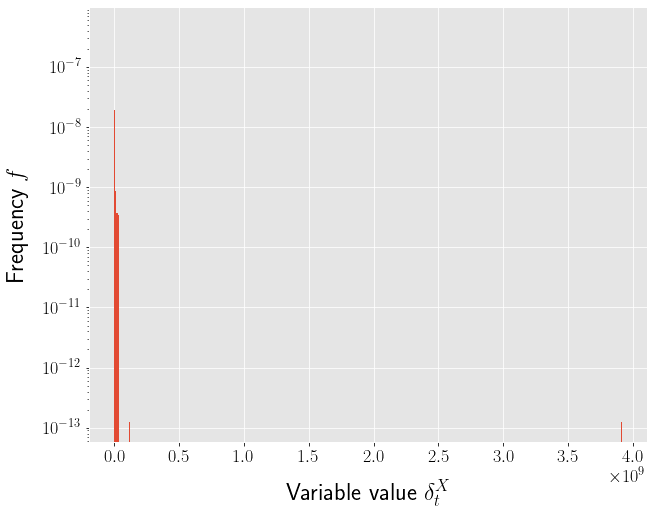

In [14]:
data_hist(file, 'input1', diff_order=1, log=True, xlabel=r'Variable value $\delta^X_t$')

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 1
	 selection: [('idle', True)]
	 crop values: 843694, 843694
	 # of elements: 2531083
	 # of bins: 1590
	 log = False


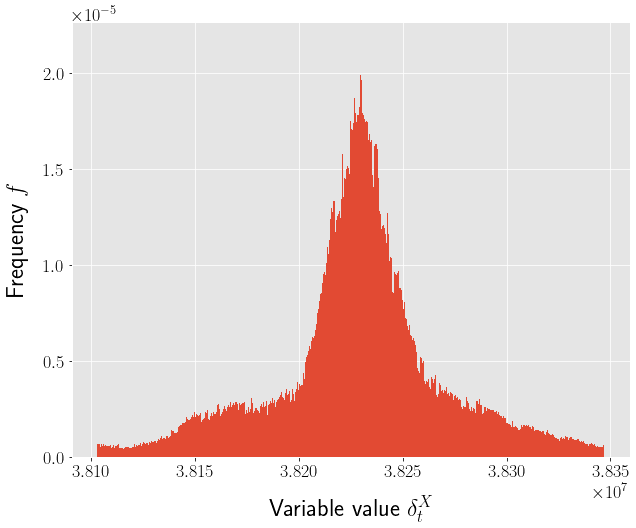

In [26]:
data_hist(file, 'input1', diff_order=1, selection=[('idle', True)], crop=(0.2, 0.2), log=False, 
         xlabel=r'Variable value $\delta^X_t$', boxplot=True)

### 2) Correlogram

Correlogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 1
	 selection: []
	 crop values: 0, 0
	 # of elements: 4241739


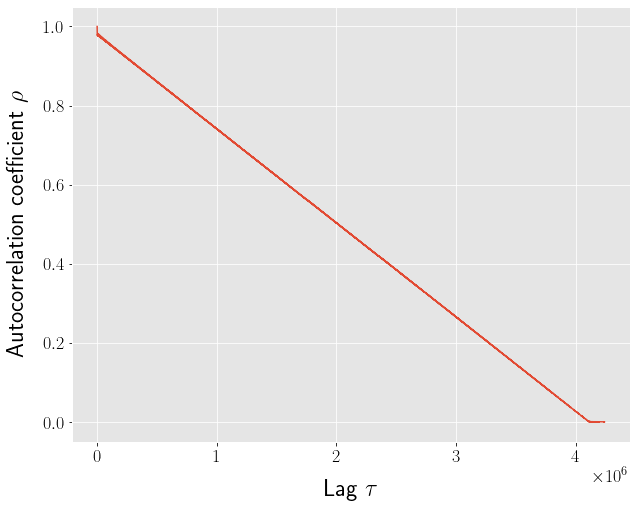

In [18]:
data_autocorr(file, 'input1', mode='fft', diff_order=1)

Correlogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 1
	 selection: []
	 crop values: 0, 0
	 # of elements: 4241739


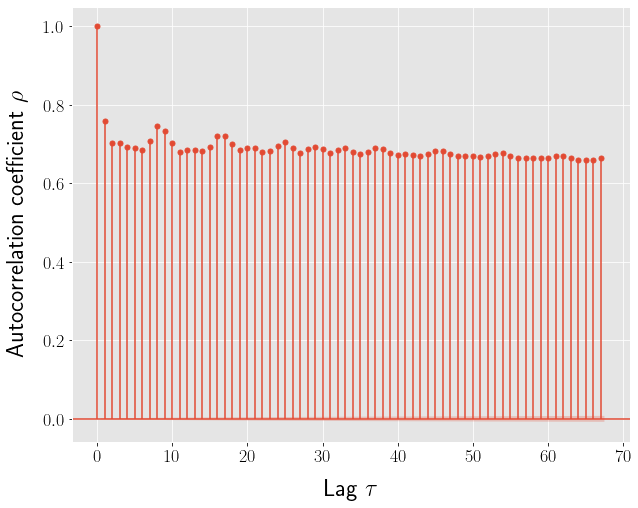

In [19]:
data_autocorr(file, 'input1', mode='acf', diff_order=1)

## C. Second-Order Differencing

### 1) Histogram

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 2
	 selection: []
	 crop values: 0, 0
	 # of elements: 4241739
	 # of bins: 2059
	 log = True


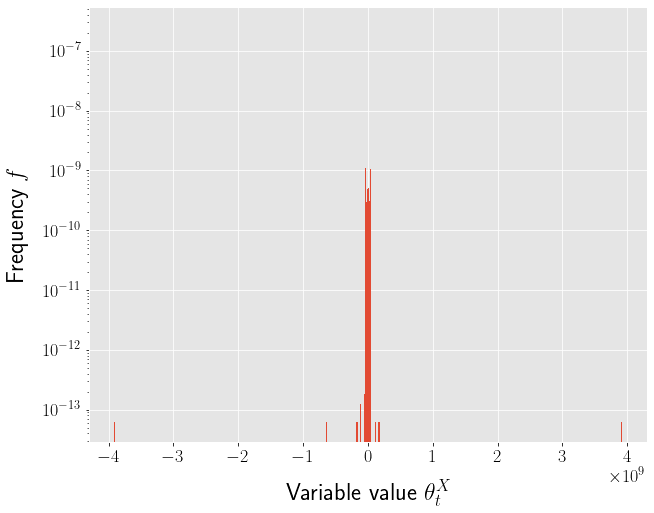

In [15]:
data_hist(file, 'input1', diff_order=2, log=True, xlabel=r'Variable value $\theta^X_t$')

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 2
	 selection: [('idle', True)]
	 crop values: 843694, 843694
	 # of elements: 2531083
	 # of bins: 1590
	 log = False


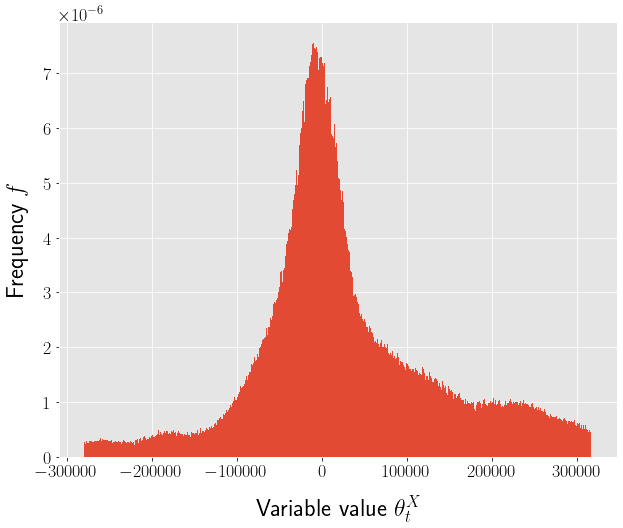

In [34]:
data_hist(file, 'input1', diff_order=2, selection=[('idle', True)], crop=(0.2, 0.2), log=False,
         xlabel=r'Variable value $\theta^X_t$', boxplot=True)

### 2) Autocorrelation

Correlogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 2
	 selection: []
	 crop values: 0, 0
	 # of elements: 4241739


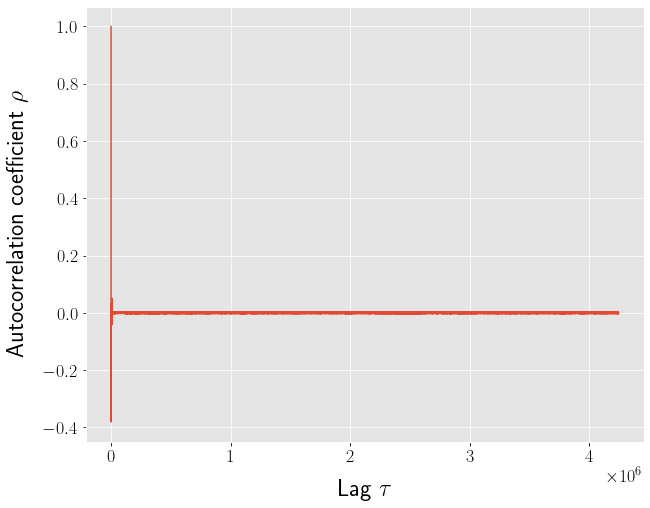

In [21]:
data_autocorr(file, 'input1', mode='fft', diff_order=2)

Correlogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 2
	 selection: []
	 crop values: 0, 0
	 # of elements: 4241739


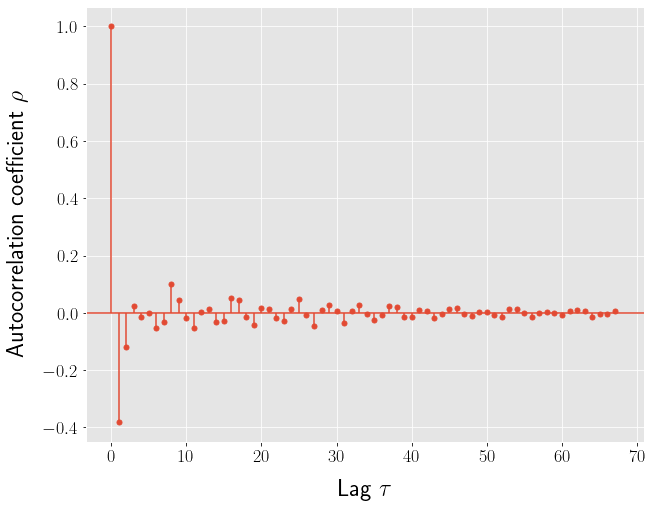

In [22]:
data_autocorr(file, 'input1', mode='acf', diff_order=2)

## D. Model

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 differencing order: 2
	 selection: []
	 crop values: 848347, 848347
	 # of elements: 2545045
	 # of bins: 1595
	 log = False


Fitting 1 distributions: 100%|███████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


	 Model parameters: scale=48031.94675617411 location=3818.9631948687347
	 KS test: statistic=0.07590385934303978, pvalue=0.0


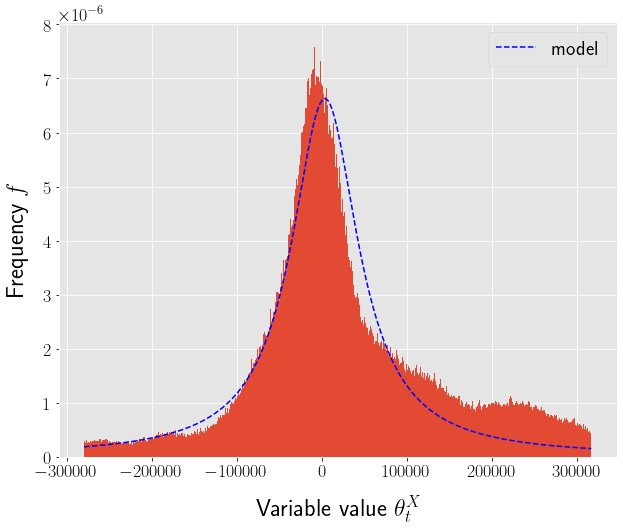

In [50]:
data_hist(file, 'input1', diff_order=2, selection=[], crop=(0.2, 0.2), log=False,
         xlabel=r'Variable value $\theta^X_t$', boxplot=True, model="cauchy")